In [3]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.decomposition import PCA

In [34]:
RR_Classifier.get_test_score??

In [32]:
class RR_Classifier:
    '''
    class RR_Classifier(self,data)
        Note:
            原始版本
            
        一个用来做图像二分类的class,该class内部包括一共2组分类器,这里用clfs和svms来分别称呼它们.
        clfs包括mlp(神经网络),Rnf(随机森林),Svm_Poly(多项式支持向量机),Voting(以上三者的集成分类器).
        svms包括Poly(多项式支持向量机),Linear(线性支持向量机),Rbf(高斯核支持向量机).
        class内部以特异度(specificity),准确性(accuracy),召回率(recall)，ROC曲线作为分类器性能的评判标准.
        通过调用内部函数，可以获得2组分类器对应的ROC曲线图和得分柱状图.
        对象创建成功时,会自动对特征进行标准化,将数据集划分为75%的训练集,25%的测试集.
        
    Parameters:
              data:xls或xlsx形式.要求col(列)=55,其中2-54col为特征指,最后一列即55col为分类结果.
                   其中,分类结果必须要求为数字形式(如int,float等)
    '''
    
    methods=["test","cross"]
    modes=["clfs","svms"]
    targets=["specificity","accuracy","recall"]
    
    clf_names=["Mlp","Rnf","Svm_Poly","VotingClassifier"]
    clfs_cross_title="Clfs_Cross_value_score"
    clfs_test_title="Clfs_Test_score"
    
    svm_names=["Poly","Linear","Rbf"]
    svms_cross_title="Svms_Cross_value_score"
    svms_test_title="Svms_Test_score"
    
    def __init__(self,data):      
        self.font={'family' : 'Times New Roman',
                   'weight' : 'normal',
                   'size'   : 23}
        self.data=pd.read_excel(data)
        self.X=self.data.iloc[:,1:54]
        self.y=self.data.iloc[:,-1]
        self.X_train,self. X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, random_state=666)
        self.scaled_X_train=0
        self.scaled_X_test=0
        self.rf_clf=RandomForestClassifier()
        self.mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                            hidden_layer_sizes=(5, 2), random_state=1)
        self.svm_linear_clf=SVC(kernel="linear",C=1,probability=True)
        self.svm_poly_clf=SVC(kernel="poly",degree=3,coef0=1,probability=True)
        self.svm_rbf_clf=SVC(kernel="rbf",gamma=5,C=0.1,probability=True)
        self.vote_clf=VotingClassifier(
                    estimators=[("mlp",self.mlp_clf),("rf",self.rf_clf),("svc",self.svm_poly_clf)],
                    voting="soft"
                )
        self.clfs=[self.mlp_clf,self.rf_clf,self.svm_poly_clf,self.vote_clf]
        self.svms=[self.svm_poly_clf,self.svm_linear_clf,self.svm_rbf_clf]
        self.clfs_cross_scores=dict()
        self.svms_cross_scores=dict()
        self.clfs_test_scores=dict()
        self.svms_test_scores=dict()
        

    def score_process(score):
        score=list(map(lambda x:float("%.2f"%x),score))
        
        return score
        
    def data_scaler(self):
        scaler=StandardScaler()
        self.X_train,self. X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, random_state=666)
        scaled_X_train=scaler.fit_transform(self.X_train.astype(np.float64))
        scaled_X_test=scaler.fit_transform(self.X_test.astype(np.float64))
        
        self.scaled_X_train= scaled_X_train
        self.scaled_X_test=scaled_X_test
        
    
    def Pca(self,target=0.95):
        try:
            pca=PCA()
            X2D=pca.fit_transform(self.X)
            cumsum=np.cumsum(pca.explained_variance_ratio_)
            d=np.argmax(cumsum>=target)
            
            print("当前方差解释率:%s,维度数:%s"%(cumsum[d],d+1))
            self.X=X2D[:,0:d+1]
            
            with plt.style.context("ggplot"):
                fig,ax=plt.subplots(figsize=(12,8))
                
                x=np.arange(1,len(cumsum)+1)
                ax.scatter(x,cumsum)
                ax.vlines(x=d+1, ymin=0, ymax=cumsum[d],linestyles="dotted")
                
                text=str(cumsum[d])
                ax.annotate(text,
                xy=(d+1, cumsum[d]),
                xytext=(d+1+4, cumsum[d]-0.5),
                arrowprops=dict(facecolor='black',shrink=0.5))

                ax.set_xlabel("n_components")
                ax.set_ylabel("variance_ratio")
                ax.set_title("PCA")
        except Exception :
            print("方差解释率应是一个浮点数，并小于1,请重新选择")
            
    def get_test_score(self,mode,target=None,name=None):
        '''
        RR_Classifier.get_test_score(self,mode,target=None,name=None)
        选择一组分类器对训练集进行训练,对测试集进行分类,并将分类分数写入对象内部.
        
        Parameters:mode:str,["clfs","svms"]
                          从以上2个中选择一组分类器
                   target:str,optional,["specificity","accuracy","recall"]
                          从以上3个指标中选择一个，默认为None.
                   name:str,optional,["Mlp","Rnf","Svm_Poly","VotingClassifier"],["Poly","Linear","Rbf"]
                          从以上7个分类器名字中选择一个,默认为None.
                          
        Note: (1)若target不等于None,name等于None时,输出该组分类器的1项指标(target)
              (2)若target等于None,name不等于None时,输出单个分类器(name)的3项指标(specificity,accuracy,recall)
              (3)若target不等于None,name不等于None时,输出单个分类器(name)的1项指标(target)
              (4)若target等于None,name等于None时(即默认状态),不输出任何指标
        '''
        scores=dict()
        spe_scores=dict()
        acc_scores=dict()
        rec_scores=dict()
        
      
        if mode==RR_Classifier.modes[0]:
            clfs=self.clfs
            names=RR_Classifier.clf_names
        elif mode==RR_Classifier.modes[1]:
            clfs=self.svms
            names=RR_Classifier.svm_names
        else:
            print("mode参数有误,请在{}中选择一个".format(RR_Classifier.modes))
            return 

        for clf,n in zip(clfs,names):
                clf.fit(self.scaled_X_train,self.y_train)
                y_pred = clf.predict(self.scaled_X_test)

                m=confusion_matrix(self.y_test, y_pred)
                spe_score=m[0][0]/(m[0][0]+m[0][1])
                spe_scores[n]=spe_score

                acc_score=clf.score(self.scaled_X_test,self.y_test)
                acc_scores[n]=acc_score

                rec_score=recall_score(self.y_test,y_pred)
                rec_scores[n]=rec_score
        temp=[spe_scores,acc_scores,rec_scores]

        for t,s in zip(RR_Classifier.targets,temp):
            scores[t]=s


        if mode==RR_Classifier.modes[0]:
            self.clfs_test_scores=scores
        else:
            self.svms_test_scores=scores

            
        if (target is not None) & (name is not None):
            if target not in RR_Classifier.targets:
                print("分类器指标参数输入错误,请在{}中选择一个".format(RR_Classifier.targets))
                return 
            elif name not in names:
                print("分类器名字参数输入错误,请在{}中选择一个".format(names))
                return
            print("%s %s:%s"%(name,target,scores[target][name]))
        elif (target is not None) & (name is None):
            if target not in RR_Classifier.targets:
                print("分类器指标参数输入错误,请在{}中选择一个".format(RR_Classifier.targets))
                return 
            else:
                print("%s %s"%(target,scores[target]))
        elif (target is None) & (name is not None):
            if name not in names:
                print("分类器名字参数输入错误,请在{}中选择一个".format(names))
                return
            else:
                print("%s:\n"%(name))
                for n in RR_Classifier.targets:
                    print("%s:%s\n"%(n,scores[n][name]))
    
    def get_cross_score(self,mode,target=None,name=None):
        '''
        RR_Classifier.get_cross_score(self,mode,target=None,name=None)
        选择一组分类器做交叉检验,并将得分写入对象内部.
        
        Parameters:mode:str,["clfs","svms"]
                          从以上2个中选择一组分类器
                   target:str,optional,["specificity","accuracy","recall"]
                          从以上3个指标中选择一个，默认为None.
                   name:str,optional,["Mlp","Rnf","Svm_Poly","VotingClassifier"],["Poly","Linear","Rbf"]
                          从以上7个分类器名字中选择一个,默认为None.
                          
        Note: (1)若target不等于None,name等于None时,输出该组分类器的1项指标(target)
              (2)若target等于None,name不等于None时,输出单个分类器(name)的3项指标(specificity,accuracy,recall)
              (3)若target不等于None,name不等于None时,输出单个分类器(name)的1项指标(target)
              (4)若target等于None,name等于None时(即默认状态),不输出任何指标
        '''
        scores=dict()
        spe_scores=dict()
        acc_scores=dict()
        rec_scores=dict()
        temp=[spe_scores,acc_scores,rec_scores]
        
        if mode==RR_Classifier.modes[0]:
            clfs=self.clfs
            names=RR_Classifier.clf_names
        elif mode==RR_Classifier.modes[1]:
            clfs=self.svms
            names=RR_Classifier.svm_names
        else:
            print("分类器参数有误,请在{}中选择一个".format(RR_Classifier.modes))
            return 
        
        
        for clf,n in zip(clfs,names):
            for t,s in zip(RR_Classifier.targets,temp):
                if t=="specificity":
                    y_pred=cross_val_predict(clf,self.scaled_X_train,self.y_train,cv=3)
                    m=confusion_matrix(self.y_train,y_pred)
                    cross_scores=m[0][0]/(m[0][0]+m[0][1])
                    cross_score=np.mean(cross_scores)
                else:  
                    cross_scores=cross_val_score(clf,self.scaled_X_train,self.y_train,cv=3,scoring=t)
                    cross_score=np.mean(cross_scores)
                s[n]=cross_score
                t=s[n]
        
        for t,s in zip(RR_Classifier.targets,temp):
            scores[t]=s      
        
        if mode==RR_Classifier.modes[0]:
            self.clfs_cross_scores=scores
        else:
            self.svms_cross_scores=scores
            
        if (target is not None) & (name is not None):
            if target not in RR_Classifier.targets:
                print("分类器指标参数输入错误,请在{}中选择一个".format(RR_Classifier.targets))
                return 
            elif name not in names:
                print("分类器名字参数输入错误,请在{}中选择一个".format(names))
                return
            print("%s %s:%s"%(name,target,scores[target][name]))
        elif (target is not None) & (name is None):
            if target not in RR_Classifier.targets:
                print("分类器指标参数输入错误,请在{}中选择一个".format(RR_Classifier.targets))
                return 
            else:
                print("%s %s"%(target,scores[target]))
        elif (target is None) & (name is not None):
            if name not in names:
                print("分类器名字参数输入错误,请在{}中选择一个".format(names))
                return
            else:
                print("%s:\n"%(name))
                for n in RR_Classifier.targets:
                    print("%s:%s\n"%(n,scores[n][name]))
                    
    def score_bar(self,method,mode):
        '''
        RR_Classifier.score_bar(self,method,mode)
        画出一组分类器在交叉检验或测试集中得分的情况
        
        Parameters：method:str,["test","cross"]
                           选择测试集或是交叉检验
                    mode:str,["clfs","svms]
                            选择哪一组分类器
                    
        '''
        try:
            with plt.style.context("fivethirtyeight"):
                fig,ax=plt.subplots(figsize=(12,8))
                if (method is not None) & (mode is not None) :
                    if method not in RR_Classifier.methods:
                        print("分类器性能检验参数有误,请在{}中输入一个".format(RR_Classifier.methods))
                        return
                    if mode not in RR_Classifier.modes:
                        print("分类器组参数有误,请在{}中选择一个".format(RR_Classifier.modes))
                        return
                    else:
                        if mode=="clfs":
                            label_list=RR_Classifier.clf_names
                            if method=="test":
                                title=RR_Classifier.clfs_test_title
                                scores=self.clfs_test_scores
                            else:
                                title=RR_Classifier.clfs_cross_title
                                scores=self.clfs_cross_scores
                        else:
                            label_list=RR_Classifier.svm_names
                            if method=="test":
                                title=RR_Classifier.svms_test_title
                                scores=self.svms_test_scores
                            else:
                                title=RR_Classifier.svms_cross_title 
                                scores=self.svms_cross_scores


                x=np.arange(len(scores[RR_Classifier.targets[0]]))+0.3

                h=[list(scores[RR_Classifier.targets[1]].values()),list(scores[RR_Classifier.targets[2]].values()),\
                  list(scores[RR_Classifier.targets[0]].values())]

                rects1 = ax.bar(x=x, height=h[0],\
                                width=0.3, alpha=0.8, label="Accuracy") 
                rects2 = ax.bar(x=[i + 0.3 for i in x], height=h[1],\
                                width=0.3, label="Recall")
                rects3 = ax.bar(x=[i + 0.6 for i in x], height=h[2], \
                                width=0.3, label="Specifity")

                ax.grid(True)
                ax.set_ylim(0, 1)
                ax.set_xlim(-0.15, 5)
                ax.set_ylabel("Percent",self.font)
                plt.yticks(fontproperties = 'Times New Roman', size = 14)
                plt.xticks(fontproperties = 'Times New Roman', size = 14)

                ax.set_xticks([index + 0.3 for index in x])
                ax.set_xticklabels(label_list,rotation=45)

                for rect in rects1: 
                    height = rect.get_height()
                    height = float(("%.2f" % height))
                    ax.text(rect.get_x() + rect.get_width() / 2, height-0.2, str(height), ha="center", va="bottom") 
                for rect in rects2: 
                    height = rect.get_height()
                    height = float(("%.2f" % height))
                    ax.text(rect.get_x() + rect.get_width() / 2, height-0.2, str(height), ha="center", va="bottom") 
                for rect in rects3: 
                    height = rect.get_height()
                    height = float(("%.2f" % height))
                    ax.text(rect.get_x() + rect.get_width() / 2, height-0.2, str(height), ha="center", va="bottom")
                ax.set_title(title,self.font) 
                ax.legend()
                plt.show()
        except Exception as e:
                print("分类器还未训练，在使用这个函数前请先使用fit()")
            
    def fit(self,Pca_target=0.95,Pca="on"):
        '''
        训练2组分类器,将训练结果写入对象内部.
        '''
        if Pca=="on":
            self.Pca(Pca_target)
            self.data_scaler()
        elif Pca=="off":
            self.data_scaler()
            
        for m in RR_Classifier.modes:
            self.get_cross_score(mode=m)
            self.get_test_score(mode=m)
        
     
    def get_scores(self,m):
        l=list()
        
        for t in RR_Classifier.targets:
            l.append(list(m[t].values()))
        return l
    
    def plot_score_bars(self):
        '''
        输出2组分类器,分别在交叉验证和测试集中的表现.
        '''
        try:
            with plt.style.context("fivethirtyeight"):
                fig,ax=plt.subplots(2,2,figsize=(16,16))

                cross_scores=[self.get_scores(i) for i in [self.clfs_cross_scores,self.svms_cross_scores]]
                test_scores=[self.get_scores(i) for i in [self.clfs_test_scores,self.svms_test_scores]]

                cross_titles=[RR_Classifier.clfs_cross_title,RR_Classifier.svms_cross_title]
                test_titles=[RR_Classifier.clfs_test_title,RR_Classifier.svms_test_title]
                titles=[cross_titles,test_titles]

    #             xs=[np.arange(len(i))+0.3 for i in [cross_scores[0][0],test_scores[1][0]]]
                xs=[np.array([1, 4.5, 8, 11.5]), np.array([1, 3.5, 6])]

                names=[RR_Classifier.clf_names,RR_Classifier.svm_names]

                for i in np.arange(2):               
                    for j in np.arange(2):
                        if j==1:
                            rects1 = ax[j][i].bar(x=xs[j], height=cross_scores[j][1],\
                                            width=0.5, alpha=0.8, label="Accuracy") 
                            rects2 = ax[j][i].bar(x=[i + 0.5 for i in xs[j]], height=cross_scores[j][2],\
                                            width=0.5, label="Recall")
                            rects3 = ax[j][i].bar(x=[i + 1 for i in xs[j]], height=cross_scores[j][0], \
                                            width=0.5, label="Specifity")
                        else:
                            rects1 = ax[j][i].bar(x=xs[j], height=cross_scores[j][1],\
                                        width=0.7, alpha=0.8, label="Accuracy") 
                            rects2 = ax[j][i].bar(x=[i + 0.7 for i in xs[j]], height=cross_scores[j][2],\
                                        width=0.7, label="Recall")
                            rects3 = ax[j][i].bar(x=[i + 1.4 for i in xs[j]], height=cross_scores[j][0], \
                                        width=0.7, label="Specifity")
                        ax[j][i].grid(True)
                        ax[j][i].set_ylim(0, 1)
                        if j==1:
                            ax[j][i].set_xlim(-0.15, 11)
                        else:
                            ax[j][i].set_xlim(-0.15, 18)
                        ax[j][i].set_ylabel("Percent",self.font)
    #                     ax[j][i].set_yticks(font = 'Times New Roman', size = 14)
    #                     ax[j][i].set_xticks(font = 'Times New Roman', size = 14)

                        ax[j][i].set_xticks([index + 0.3 for index in xs[j]])
                        ax[j][i].set_xticklabels(names[j],rotation=45)

                        if j==0:
                            fs=8
                        else:
                            fs=10
                        for rect in rects1: 
                            height = rect.get_height()
                            height = float(("%.2f" % height))
                            ax[j][i].text(rect.get_x() + rect.get_width() / 2, height*4/5, str(height), fontsize=fs,\
                                          ha="center", va="bottom") 
                        for rect in rects2: 
                            height = rect.get_height()
                            height = float(("%.2f" % height))
                            ax[j][i].text(rect.get_x() + rect.get_width() / 2, height*4/5, str(height), fontsize=fs,\
                                          ha="center", va="bottom") 
                        for rect in rects3: 
                            height = rect.get_height()
                            height = float(("%.2f" % height))
                            ax[j][i].text(rect.get_x() + rect.get_width() / 2, height*4/5, str(height),fontsize=fs,\
                                          ha="center", va="bottom")
                        ax[j][i].set_title(titles[i][j],self.font) 
                        ax[j][i].legend(fontsize="small")

            plt.subplots_adjust(wspace =0.3, hspace =0.7)           
            plt.show()
        except Exception as e:
            print("分类器还未训练，在使用这个函数前请先使用fit()")
        
    def plot_roc(self):
        '''
        画出2组分类器在测试集上的ROC曲线
        '''
        try :
            with plt.style.context("ggplot"):
                
                fig,ax=plt.subplots(1,2,figsize=(12,8))
                
                y_probs=list()
                y_preds=list()
                
                clfs_y_probs=list()
                clfs_y_preds=list()
                
                svms_y_probs=list()
                svms_y_preds=list()
                
                for clf,svm in zip(self.clfs,self.svms):
                    clfs_y_prob = clf.predict_proba(self.scaled_X_test)
                    clfs_y_pred=clf.predict(self.scaled_X_test)
                    
                    svms_y_prob = svm.predict_proba(self.scaled_X_test)
                    svms_y_pred=svm.predict(self.scaled_X_test)
    
                    clfs_y_preds.append(clfs_y_pred)
                    clfs_y_probs.append(clfs_y_prob) 
            
                    svms_y_preds.append(svms_y_pred)
                    svms_y_probs.append(svms_y_prob)
            
                clfs_y_prob = self.clfs[-1].predict_proba(self.scaled_X_test)
                clfs_y_pred=self.clfs[-1].predict(self.scaled_X_test)
                clfs_y_preds.append(clfs_y_pred)
                clfs_y_probs.append(clfs_y_prob)
                
                y_probs=[clfs_y_probs,svms_y_probs]
                y_preds=[clfs_y_preds,svms_y_preds]
            
               
                titles=["Clfs_ROC","Svms_ROC"]
                labels=[RR_Classifier.clf_names,RR_Classifier.svm_names]
                
                t_fprs=list()
                t_tprs=list()
                t_thresholds=list()
                
                for i in np.arange(len(y_probs)):
                        fprs=list()
                        tprs=list()
                        thresholds=list()
                        for j in np.arange(len(y_probs[i])):
                            fpr,tpr,threshold=roc_curve(self.y_test,y_probs[i][j][:,1])
                            fprs.append(fpr)
                            tprs.append(tpr)
                            thresholds.append(threshold)
                        t_fprs.append(fprs)
                        t_tprs.append(tprs)
                        t_thresholds.append(thresholds)
                        
                for i in range(2):
                    for j in range(len(labels[i])):
                     ax[i].plot(t_fprs[i][j],t_tprs[i][j],linewidth=2,label=labels[i][j])
                     ax[i].plot([0,1],[0,1],"k--")
                     ax[i].axis([0,1,0,1])
                     ax[i].legend()
                     ax[i].set_title(titles[i],self.font)
                     ax[i].set_xlabel("False Positive Rate",self.font)
                     ax[i].set_ylabel("True Positive Rate",self.font) 
                        
                plt.show()
        except Exception as e:
                print("分类器还未训练，在使用这个函数前请先使用fit()")


In [16]:
rr_clf.scaled_X_train.shape

(231, 53)

当前方差解释率:0.981253099465561,维度数:1


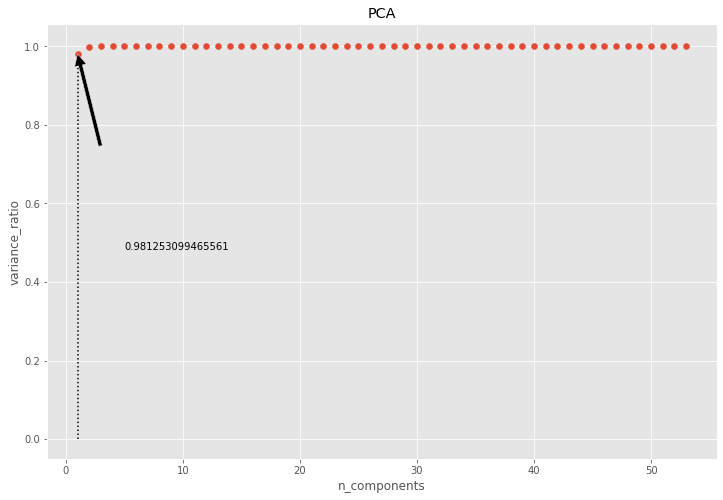

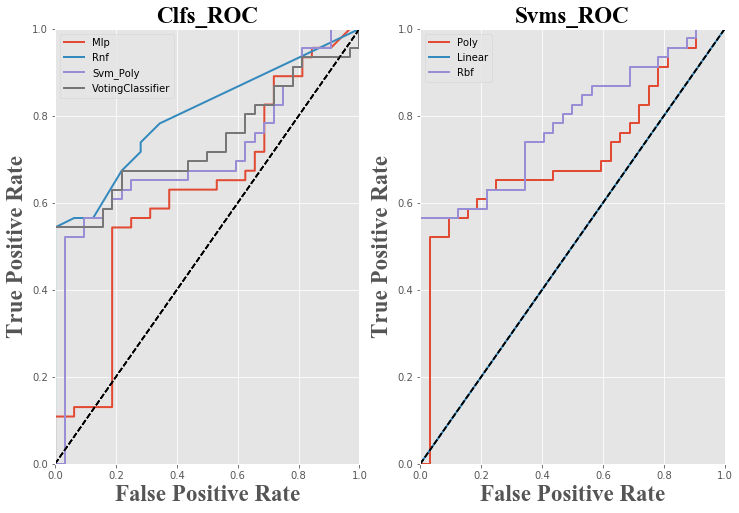

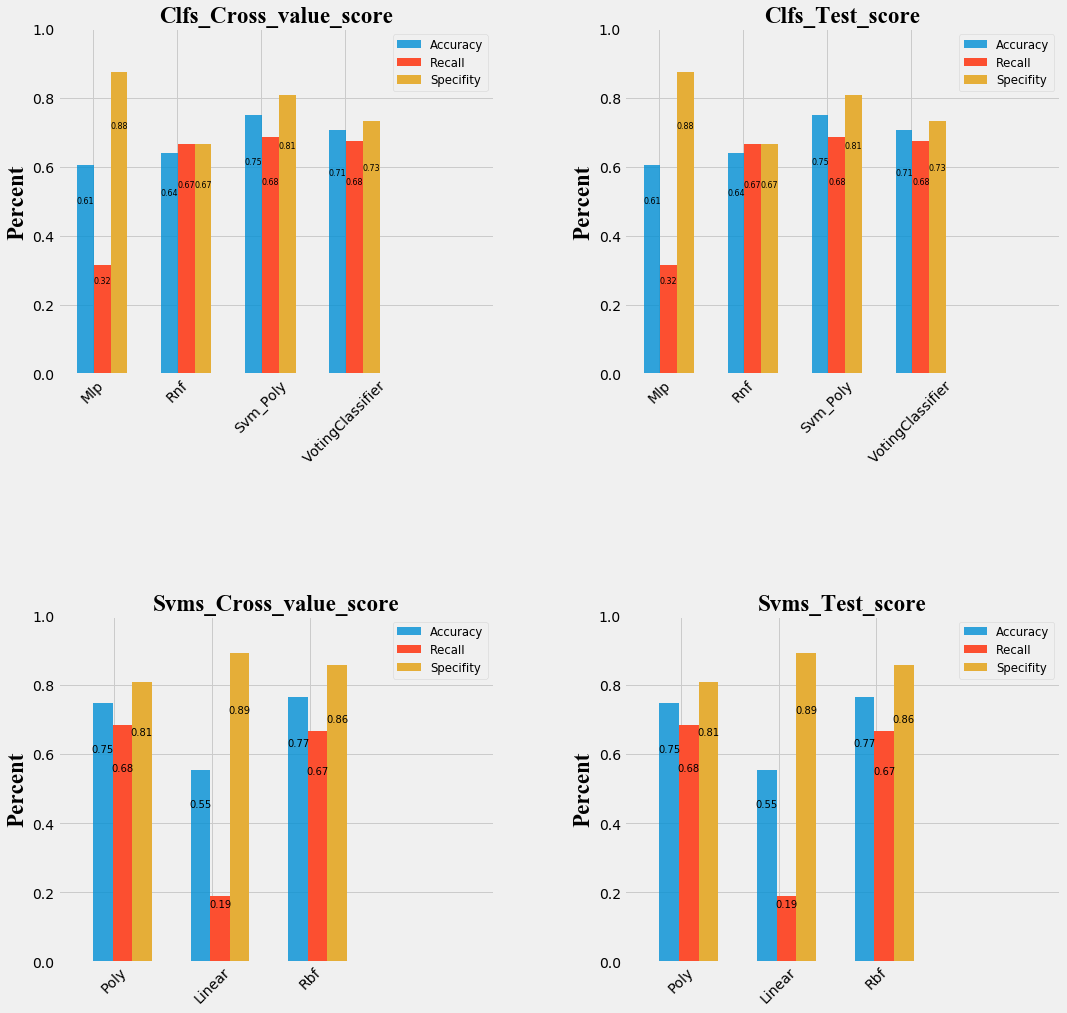

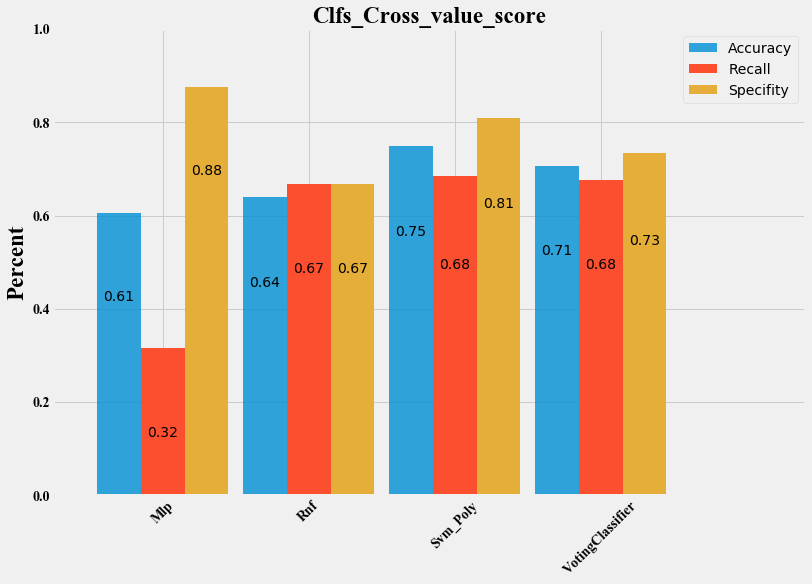

In [34]:
if __name__ == '__main__':
    rr_clf=RR_Classifier("result_01.xls")
    rr_clf.fit()
    rr_clf.plot_roc()
    rr_clf.plot_score_bars()
    rr_clf.score_bar(method="cross",mode="clfs")

In [40]:
rr_clf.get_test_score(mode="svms",target="accuracy",name="Poly")

Poly accuracy:1.0
